# Bayesian Constraints on the Mean Molecular Gas Fraction of Galaxy Populations
_Hai Fu, July 2022_

***Data***: 
- CO Luminosities and Line Widths from a population of galaxies within a narrow redshift range

***Assumptions***: 
1. random disk orientations 
2. a non-evolving CO Baryonic Tully-Fisher relation
3. comparable fractional measurement errors for all galaxies in a population (which is likely when measured with the same instrument)

***Reference***: 
- [Isbell, Xue, and Fu 2018 ApJ Letter](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..37I/)

***Required Python Modules***:
- emcee
- multiprocessing
- os
- numpy
- matplotlib
- h5py
- astropy

In [1]:
# fork: copy a Python process from an existing process.
import multiprocessing
multiprocessing.set_start_method("fork")

# disable automatic parallelization in NumPy
import os
os.environ["OMP_NUM_THREADS"] = "1"

## Summary of the Method

The $\alpha_{\rm CO}$-normalized molecular gas fraction is defined as:
$$
f_{\rm mol}^\prime \equiv \frac{f_{\rm mol}}{\alpha_{\rm CO}} = \frac{M_{\rm mol}}{{M_{\rm bary}}} / \frac{M_{\rm mol}}{L^{\prime}_{\rm CO}} = \frac{L^{\prime}_{\rm CO}}{{M_{\rm bary}}}.
$$
Its logarithmic can be estimated from each CO measurement pair of $L'_{\rm CO}$ and $w$:
\begin{aligned}
    \log f_{\rm mol}^\prime &\equiv \log f_{\rm mol}/\alpha_{\rm CO} \\
    &= \log L^{\prime}_{{\rm CO, true}} - \log M_{{\rm bary, true}} \\
	&= (\log {L'_{{\rm CO}}} - \epsilon_{L}) - [a + b (\log{w}-\log(\sin\,i)-\epsilon_{w}-c)].
\end{aligned}
where the random variables ($\epsilon_w$ and $\epsilon_L$) represent the fractional measurement errors and we used the Tully-Fisher relation to predict the baryonic mass:
$$
    \log\left(\frac{M_{\rm bary}}{M_{\odot}}\right) = a + b \left[\log\left(\frac{W}{\rm km~s}\right)-c\right],
$$
where the constants are:
\begin{aligned}
a &= 10.61\pm0.04\\
b &= 3.3\pm0.3\\
c &= 2.58.
\end{aligned}

However, because the inclination angle ($i$) is unknown from spatially unresolved CO measurements, we can not use the above equation directly to calculate $f_{\rm mol}^\prime$ for each individual galaxy. Our solution is to constrain $f_{\rm mol}^\prime$ using galaxy populations and assume the galaxies within each population are randomly oriented on the sky (i.e., the probability density function [PDF] of $i$ is $f_i(x) = \sin x$ for $0 \leq x \leq \pi/2$ where $i = 0$ is face-on.).

We first rearrange the equation so that the left side contains only observables ($L'_{{\rm CO}}, w$), while the right side contains only random variables ($\sin i$, $\epsilon$) and the parameter to be inferred ($f_{\rm mol}^\prime$):
\begin{aligned}
  \log {L'_{{\rm CO}}} - [a + b(\log w-c)] 
   &= \log f_{\rm mol}^\prime + \epsilon_{L} - b\epsilon_{w} - b\log(\sin\,i) 
\end{aligned}
We then define a new random variable $X$ whose expected distribution function can be derived (see next section) and whose value can be calculated from each CO measurement pair and an assumed gas fraction:
\begin{aligned}
X &= \epsilon_{L} - b\epsilon_{w} - b\log(\sin\,i) \\
  &= \log {L'_{{\rm CO}}} - [a + b(\log w-c)] - \log f_{\rm mol}^\prime
\end{aligned}

## Likelihood Function, Priors, and Posterior Probability Function

The expected PDF of $X$ is the convolution of the PDFs of the three independent random variables and its analytical form can be derived under the reasonable assumption of random orientations of the disks. The result is an integral:
$$
f_X(x) = \frac{\ln 10}{b} \int_{0}^{\infty}\frac{10^{-2t/b}}{\sqrt{1-10^{-2t/b}}}
\frac{1}{{\sigma \sqrt {2\pi } }}e^{{ -  (x-t)^2 } / {2\sigma ^2 }} dt,
$$

The likelihood function of the observed data set $\{w_k, L'_{{\rm CO},k}\}$ given a model ($f_{\rm mol}^\prime$, $\sigma$) is the product of the probabilities of all measurement pairs from a given galaxy population: 
\begin{aligned}
p(\{w_k, L'_{{\rm CO},k}\} | f_{\rm mol}^\prime, \sigma) &= \prod_{k} f_X(x_k), \\
x_k &= \log {L'_{{\rm CO},k}} - [a + b(\log w_k-c)] - \log f_{\rm mol}^\prime.
\end{aligned}

Given the Bayes' theorem, the posterior PDF of the model constrained by the data is then:
$$
p(f_{\rm mol}^\prime, \sigma |\{w_k, L'_{{\rm CO},k}\}) \propto p( f_{\rm mol}^\prime, \sigma) p(\{w_k, L'_{{\rm CO},k}\} | f_{\rm mol}^\prime, \sigma).
$$

We assume bounded ``flat'' priors for both $\log f_{\rm mol}^\prime$ and $\sigma$: $-10 \leq \log f_{\rm mol}^\prime \leq 10$ and $0 \leq \sigma \leq 10$. 

In [2]:
import numpy as np 
import scipy.integrate as integrate

def ln_prior(theta):
    # get model parameters
    logf, sigm = theta
    # flat prior inside the bounds
    if -10.0 < logf < 10.0 and 0.0 < sigm < 10.0:
        return 0.0
    return -np.inf

def pdf_intfun(t,x,sigm,b):
    # function inside the integral
    tmp = 10.**(-2*t/b)
    fun = np.log(10)/b \
        * tmp/np.sqrt(1-tmp) \
        * 1./sigm/np.sqrt(2*np.pi) \
        * np.exp(-(x-t)**2.0/2/(sigm**2.0))
    return fun

def pdf_eva(x,sigm,b):
    # integrate the function from 0 to inf
    result=integrate.quad(pdf_intfun, 0.0, np.inf, args=(x,sigm,b))
    return result[0]

def ln_likelihood(theta, w50, lco):
    # get model parameters
    logf, sigm = theta
    # define TFR
    a = 10.61
    b = 3.3
    c = 2.58
    # evaluate X using CO measurement pairs
    xs = np.log10(lco) - (a+b*(np.log10(w50)-c)) - logf
    # calculate the probability of getting the measurements given the model
    ys = np.array([pdf_eva(x,sigm,b) for x in xs])
    # return the sum of the logarithmic
    return np.sum(np.log(ys[np.where(ys > 0)]))

def ln_probability(theta, w50, lco):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(theta, w50, lco)

## Read CO Measurements

In [3]:
from astropy.io import fits 

dir = './data/'
group = 'local_sfgs'
hdu = fits.open(dir+group+'.fits')
data = hdu[1].data
w50 = data['w50'] # km/s
lco = data['lco'] # cgs unit

# test the likelihood function
print(ln_likelihood([-1.8,0.46],w50,lco))

-222.64936767507606


## Sample the Posterior with MCMC

First, a test run of a small number of steps to compare serial and multi-processing. 

In [4]:
# test run
import emcee
import time

# starting guess position
logf_guess, sigm_guess = -2.0, 0.3
pos = [logf_guess,sigm_guess] + 1e-1 * np.random.randn(32, 2) # 32 walkers
nwalkers, ndim = pos.shape
nsteps = 10 

# serial processing (107s for 20 steps)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_probability, args=(w50,lco))
start = time.time()
sampler.run_mcmc(pos, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Serialprocessing took {0:.1f} seconds".format(serial_time))

# parallelization (16s for 20 steps)
from multiprocessing import Pool
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, ln_probability, args=(w50,lco), pool=pool
    )
    start = time.time()
    sampler.run_mcmc(pos, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print(
        "Multiprocessing (with args=) took {0:.1f} seconds".format(multi_time)
    )

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/99/8vgz00517hs0qj_5nds2hck80000gq/T/ipykernel_8370/2794597816.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result=integrate.quad(pdf_intfun, 0.0, np.inf, args=(x,sigm,b))
100%|██████████| 10/10 [00:50<00:00,  5.07s/it]

Serialprocessing took 55.8 seconds



100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

Multiprocessing (with args=) took 8.6 seconds


As we found that multiprocessing is 6.9 times faster than serial processing on a 2021 Macbook Pro with a M1 Pro (10 CPU cores), we proceed with a production run using multiprocessing. We also save the `emcee` results to an HDF file with the `backends.HDFBackend` method.

In [6]:
# Production Run
from multiprocessing import Pool

# starting guess position
logf_guess, sigm_guess = -2.0, 0.3
pos = [logf_guess,sigm_guess] + 1e-1 * np.random.randn(32, 2) # 32 walkers
nwalkers, ndim = pos.shape
nsteps = 3000

# set up the backend
filename = dir+group+".h5"
if os.path.exists(filename):
    os.remove(filename)
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# start emcee
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, ln_probability, args=(w50,lco), backend=backend, pool=pool
    )
    sampler.run_mcmc(pos, nsteps, progress=True)

/var/folders/99/8vgz00517hs0qj_5nds2hck80000gq/T/ipykernel_8370/2794597816.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result=integrate.quad(pdf_intfun, 0.0, np.inf, args=(x,sigm,b))
/var/folders/99/8vgz00517hs0qj_5nds2hck80000gq/T/ipykernel_8370/2794597816.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result=integrate.quad(pdf_intfun, 0.0, np.inf, args=(x,sigm,b))
  0%|          | 0/3000 [00:00<?, ?it/s]/var/folders/99/8vgz00517hs0qj_5nds2hck80000gq/T/ipykernel_8370/2794597816.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result=integrate.quad(pdf_intfun, 0.0, np.inf, args=(x,sigm,b))
  0%|          | 1/3000 [00:00<38:01,  1.31it/s]/var/folders/99/8vgz00517hs0qj_5nds2hck80000gq/T/ipykernel_8370/2794597816.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result=integrate.quad(pdf_intfun, 0.0, np.inf, args=(x,sigm,b))
  0%|   

## Check the Results

In [7]:
# since we saved the sample to the hd5 file, we can load the sample this way
# sampler = emcee.backends.HDFBackend(filename)

# print auto-correlation time (in unit of steps)
tau = sampler.get_autocorr_time(tol=0)

# trim, thin, flatten
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)

# print results
print("Raw chain shape: {0}".format(sampler.get_chain().shape))
print("Autocorrelation Time: {0}".format(tau))
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples.shape))

Raw chain shape: (3000, 32, 2)
Autocorrelation Time: [30.9284043  31.04719835]
burn-in: 62
thin: 15
flat chain shape: (6240, 2)


In [10]:
# Print marginalized confidence intervals
from IPython.display import display, Math

labels = ["log(f_{mol}^\prime)", "\sigma"]

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

# save MCMC percentles
logf_mcmc = np.percentile(flat_samples[:,0],[16,50,84])
sigm_mcmc = np.percentile(flat_samples[:,1],[16,50,84])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

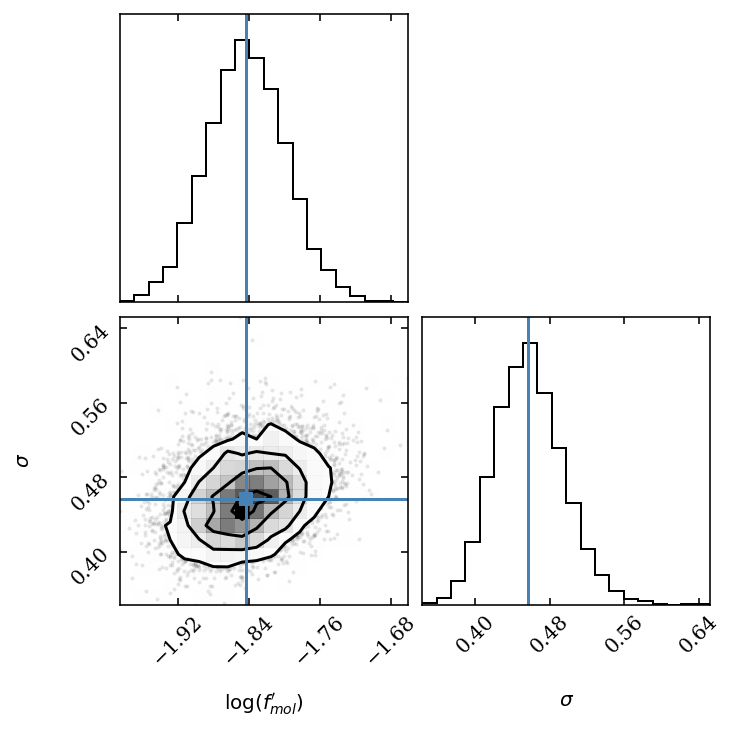

In [11]:
# make corner plot
import corner

labels = ["$\log(f_{mol}^\prime)$", "$\sigma$"]
fig = corner.corner(
    flat_samples, labels=labels, truths=[logf_mcmc[1], sigm_mcmc[1]]
);

## Project Models to Data Space

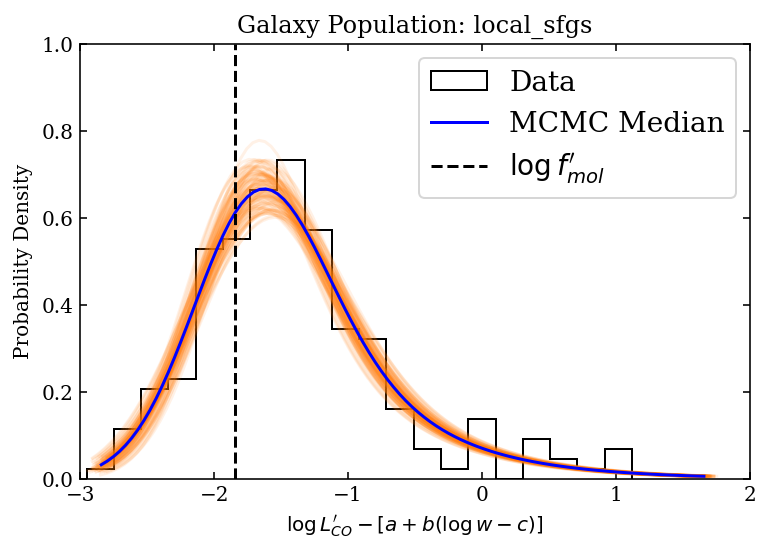

In [12]:
import matplotlib.pyplot as plt

# define TFR
a = 10.61
b = 3.3
c = 2.58

# data histogram
xdata = np.log10(lco) - (a+b*(np.log10(w50)-c))
plt.hist(xdata, 20, color="k", histtype="step", density=True, label='Data');

# a linear array of X-logf
x0 = np.linspace(-1.0,3.5,100) 

# show the range of models with transparent orange lines
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    logf,sigm = flat_samples[ind]
    y0 = [pdf_eva(x,sigm,b) for x in x0]
    plt.plot(x0+logf, y0, "C1", alpha=0.1)

# show the MCMC median solution
y0_mcmc = [pdf_eva(x,sigm_mcmc[1],b) for x in x0]
plt.plot(x0+logf_mcmc[1], y0_mcmc, "b", label='MCMC Median')
# vertical line indicating the position of logf
plt.axvline(x=logf_mcmc[1],color='k',linestyle='dashed',label='$\log f_{mol}^{\prime}$')
#plt.axvline(x=logf_mcmc[0],color='r',linestyle='dashed')
#plt.axvline(x=logf_mcmc[2],color='r',linestyle='dashed')

plt.legend(fontsize=14)
plt.xlim(-3.0, 2.0)
plt.ylim(0.0,1.0)
plt.xlabel('$\log L^{\prime}_{CO} - [a+b(\log w - c)]$')
plt.ylabel('Probability Density')
plt.title('Galaxy Population: '+group);